# Node Classification in Graphs 

### Developer: Mayana Mohsin Khan

In this Notebook, We compare text classification algorithms with Node Embedding and word embeding

### Loading the Packages

In [77]:
import pandas as pd # to manuplate the data
import networkx as nx # to create the graph
import numpy as np # to manuplate data
from node2vec import Node2Vec # to create the node vectors

In [1]:
import numpy as np # Manuplating the data
import pandas as pd # Manuplating the data
import implicit # usine als model
from sklearn.preprocessing import MinMaxScaler # scalar to normalize the value
from sklearn import metrics # to obtain accuracy
import scipy.sparse as sparse # create sparse matrix
from tqdm import tqdm # to prettify the wait time and reduce anxiety :)

In [78]:
# Loading Documents
docs = pd.read_csv('docs.txt', sep=r'\s{}' ,engine='python', header=None, names=['raw'])
docs = docs.raw.str.split(' ', 1, expand=True) # spliting it in two columns
docs.columns = ['paper_id', 'paper_title']
docs.head()

,paper_id,paper_title
0,12828558,"Assessing Local Institutional Capacity, Data A..."
1,66779408,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE...
2,38902949,"Economic Shocks, Safety Nets, and Fiscal Const..."
3,33450563,"Reform, Growth, and Poverty in Vietnam"
4,57470294,Households and Economic Growth in Latin Americ...


In [79]:
# Loading the edges from adjacent edges text file
adjEdges = pd.read_csv('adjedges.txt' ,header=None, names=['raw']) # reading the data into dataframe
adjEdges = adjEdges.raw.str.split(' ', 1, expand=True) # spliting the raw column into 2 columns based on 1st space
adjEdges.columns = ['paper_id', 'neigghbour node ID'] # Renaming columns
adjEdges['neigghbour node ID'] = adjEdges['neigghbour node ID'].str.split(' ') # Spliting the data in 2 column on space

# Padding the data with same paper_id and different neighbour node ID's
new_adj = pd.DataFrame({'paper_id':adjEdges['paper_id'].
                        repeat(adjEdges['neigghbour node ID'].str.len()),
                        'neigghbour node ID':adjEdges['neigghbour node ID'].sum()})
# Storing the data into a list o tuples in x,y format for edges
edges_array = list(map(tuple, new_adj.to_numpy()))
edges = []
for edge in range(len(edges_array)):
    if(edges_array[edge][1] != ''):
        edges.append(edges_array[edge])
edges

[('38902949', '38998399'),
 ('33450563', '26547200'),
 ('57470294', '20968604'),
 ('54791317', '9564967'),
 ('54791317', '14589786'),
 ('4289706', '48119811'),
 ('67315895', '47074959'),
 ('67315895', '36354718'),
 ('67315895', '38323242'),
 ('67315895', '40935482'),
 ('67315895', '77107975'),
 ('67315895', '38994139'),
 ('67315895', '48871207'),
 ('67315895', '75049959'),
 ('67315895', '68339148'),
 ('67315895', '62098573'),
 ('67315895', '66337421'),
 ('67315895', '78106693'),
 ('6909690', '56473434'),
 ('47982561', '26890304'),
 ('47982561', '64372150'),
 ('16864792', '9684893'),
 ('16864792', '47949816'),
 ('16864792', '47887794'),
 ('34534740', '48119811'),
 ('34534740', '16482894'),
 ('27917678', '44783549'),
 ('27917678', '24245729'),
 ('27917678', '33207680'),
 ('27917678', '66903997'),
 ('54709047', '9633322'),
 ('54709047', '32043684'),
 ('54709047', '45159388'),
 ('54709047', '54592233'),
 ('17112646', '17381885'),
 ('17112646', '33338932'),
 ('72286508', '39750483'),
 ('300

In [80]:
# Loading labels dataset
labels = pd.read_csv('labels.txt',sep = '\s+', header = None, names=['paper_id','label'])
labels = labels.astype(str)
labels.head()

,paper_id,label
0,12828558,0
1,66779408,0
2,38902949,0
3,33450563,0
4,57470294,0


## Using Network Embedding Approach

Using `node2word` embedding;

**Steps**:
- Create the graph using networkx
- Add nodes
- Add the edges
- Create node2vec object
- Create the embedding model


### Creating the Graph

In [81]:
g = nx.Graph() # Creating the graph
g.add_nodes_from(docs['paper_id'].unique().tolist()) # Adding nodes to graph
g.add_edges_from(edges) # Adding edges to graph

### node2vec

In [85]:
#pre-compute the probabilities and generate walks :
node2vec = Node2Vec(g, dimensions=64, walk_length=30, num_walks=200, workers=4)
#embed the nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

### Feature Extraction

Extracting the features from node2vec model using `model.wv.get_vector()` function.

In [86]:
# Extraing the edge features 
features = [(model.wv.get_vector(node)) for node in docs['paper_id'].tolist()]
labels['features'] = features # storing the features to labels dataframe
labels.paper_id= labels.paper_id.astype('str') # Convert paper id to string
labels.head() 

,paper_id,label,features
0,12828558,0,"[-0.0022591932, 0.0032765113, 0.0035564338, 0...."
1,66779408,0,"[-0.0033378154, 0.00097892, 0.0027823113, -0.0..."
2,38902949,0,"[0.22216897, -0.5944194, -0.06323959, 0.713916..."
3,33450563,0,"[0.14245479, -0.39015365, 0.12793119, 0.223908..."
4,57470294,0,"[-1.087529, 0.6152004, -0.14525388, 1.0902698,..."


### Machine Learning algorithms

- Using ML Algorithms

In [87]:
# Loading ML Algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

Split the data into 20% traing and rest as testing

In [88]:
np.random.seed(0) # Set Random Seed
X = labels.features.tolist() # take features as X
y = labels.label.tolist() # take labels as y
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.20) # test train Split

Comparing ML Algorithms with node embeded features.

**ML Models:**
- MLPClassifier
- LogisticRegression
- LinearSVC

Using `10 fold Cross Validation` to evaluate the accuracy on training data set.

### Building the Models

In [89]:
# List to store models
models = [
    MLPClassifier(),
    LogisticRegression(),
    LinearSVC()
]

C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Max

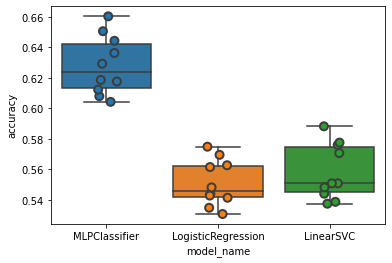

In [90]:
## Comparing Ml Models
# 10-foldCross Validation
CV = 10 
cv_df = pd.DataFrame(index=range(CV * len(models))) # empty dataframe to store the accuracies
entries = [] # Empty list to store training accuracies
# Loop to create and evaluate models
for model in models:
    # Create the models
    model_name = model.__class__.__name__
    # Get model accuracies from cross validation 
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    # Storing the accuracies
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Dataframe with model name, accuracies and fold indexes       
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Visualize the training accuracies
import seaborn as sns
import matplotlib.pyplot as plt
# plot the grpahs for accuracies
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

From the training dataset, we can see that MLP Classiefer has the highest training accuracy.

### Prediction and Model Accuracy on test sample

In [91]:
for model in models:
    # Create the models
    model_name = model.__class__.__name__
    model.fit(X_train, y_train) # fiting the model on traing data
    y_pred = model.predict(X_test) # predicting the model
    print(model_name)
    print(accuracy_score(y_test,y_pred)) # eavaluate the model accuracy
    print('-'*80)

C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier
0.6118456196581197
--------------------------------------------------------------------------------
LogisticRegression
0.5381944444444444
--------------------------------------------------------------------------------
LinearSVC
0.5488782051282052
--------------------------------------------------------------------------------


C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


On calling the models on Testing data, we can see that MLP Classifier has the best accuracy

## Using Text Embedding Approach

For Text Embedding, 
- Preform text pre-processing on Paper titles. 
- Vectorize the tokens using CountVectorizer
- Create ML Models

### Text Preprocessing

**Using Spacy for text preprocessing**

In [103]:
# Loading spacy
import spacy
from spacy.lang.en import English # loading English from spacy for parsing the titles

#### Merge docs and labels for Text Embeddings

Merging is done that we can have the titles and labes in one dataframes

In [104]:
# Merge docs and labels dataframes 
merged_docs = pd.merge(docs,labels,how='inner') # merging on inner joint
merged_docs= merged_docs.drop(['features'],axis=1) # droping the features we extracted from network embedding
merged_docs.head()

,paper_id,paper_title,label
0,12828558,"Assessing Local Institutional Capacity, Data A...",0
1,66779408,THE PROSPECTS FOR INTERNET TELEPHONY IN EUROPE...,0
2,38902949,"Economic Shocks, Safety Nets, and Fiscal Const...",0
3,33450563,"Reform, Growth, and Poverty in Vietnam",0
4,57470294,Households and Economic Growth in Latin Americ...,0


In [107]:
np.random.seed(0) # Set Random Seed
X = merged_docs.paper_title	.tolist() # take features as X
y = merged_docs.label.tolist() # take labels as y
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.20) # test train Split

In [108]:
nlp = spacy.load('en_core_web_sm') # loading the spacy model
parser = English() # creating a spacy parser

# Function for text preporcessing
def tokenizer(text):  
    doc = parser(text) # call the parser and send the text to it
    # Lemmation of titles
    tokens = [token.lemma_ for token in doc] 
    return tokens # return the tokens

#### Vectorizing titles using CountVectorizer

Since vocab in titles is less, the notebook uses `CountVectorize`r instead of `TFIDVectorizer`

In [109]:
from sklearn.feature_extraction.text import CountVectorizer # Using

# Creating the vectorizer
vectorizer=CountVectorizer(input='content', # titles
                           lowercase=True, # convert to lower case
                           token_pattern='(?u)\\b\\w\\w+\\b', # Remove punctuations
                           ngram_range=(1,2), # Generate N Grams
                           tokenizer=tokenizer # Callin spacy text processing function
                          )

In [110]:
X_train = vectorizer.fit_transform(X_train) # preform fit and transformation on training set

In [111]:
X_test = vectorizer.transform(X_test) # preform transformation on testing set

### ML Algorithms approach

C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

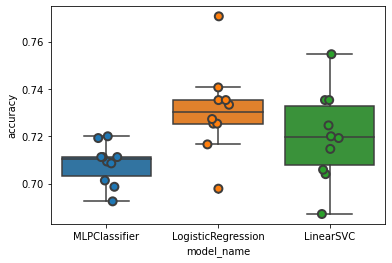

In [112]:
## Comparing Ml Models
# 10-foldCross Validation
CV = 10 
cv_df = pd.DataFrame(index=range(CV * len(models))) # empty dataframe to store the accuracies
entries = [] # Empty list to store training accuracies
# Loop to create and evaluate models
for model in models:
    # Create the models
    model_name = model.__class__.__name__
    # Get model accuracies from cross validation 
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    # Storing the accuracies
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

# Dataframe with model name, accuracies and fold indexes       
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Visualize the training accuracies
import seaborn as sns
import matplotlib.pyplot as plt
# plot the grpahs for accuracies
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

The accuracy of Logistic regression is betten then the other choosen algorithms at around 78%.

### Predicting on testing set

In [114]:
# Loop to predicit and get accuracy
for model in models:
    # Create the models
    model_name = model.__class__.__name__
    model.fit(X_train, y_train) # fiting the model on traing data
    y_pred = model.predict(X_test) # predicting the model
    print(model_name)
    print(accuracy_score(y_test,y_pred)) # eavaluate the model accuracy
    print('-'*80)

MLPClassifier
0.6979166666666666
--------------------------------------------------------------------------------


C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression
0.7361111111111112
--------------------------------------------------------------------------------
LinearSVC
0.7230235042735043
--------------------------------------------------------------------------------


C:\Users\Mohsin Khan\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


On predicition, Logistic regression given the highest testing accuracy

### Conclusion

- upon comparing the Network Embedding and Text Embedding, Text Embedding preforms better compared to Network Embedding